# 12주차 과제_0523(금)

딥러닝 파이토치 교과서 ch5. 3 p.200~229

# 5.3 전이 학습

**전이 학습**

이미지넷처럼 아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정해서 사용하는 것

아주 큰 데이터셋을 사용하여 훈련된 모델을 사전 훈련된 모델(네트워크)라고 함

딥러닝 모델 훈련 시 많은 양의 데이터를 이용해야 한다는 현실적 어려움을 해결할 수 있음

## 5.3.1 특성 추출 기법

ImageNet 데이터셋으로 사전 훈련된 모델을 가져온 후 마지막에 완전연결층 부분만 새로 만듬

즉, 학습할 때는 마지막 완전연결층만 학습하고 나머지 계층들은 학습되지 않도록 함

이미지 분류를 위해 두 부분으로 구성됨

1. 합성곱층 : 합성곱층과 풀링층으로 구성

2. 데이터 분류기(완전연결층) : 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분

사전 훈련된 네트워크의 합성곱층에 새로운 데이터를 통과시키고 그 출력을 데이터 분류기에서 훈련시킴

[사용 가능한 이미지 분류 모델]

- Xception

- Inception V3

- ResNet50

- VGG16

- VGG19

- MobileNet

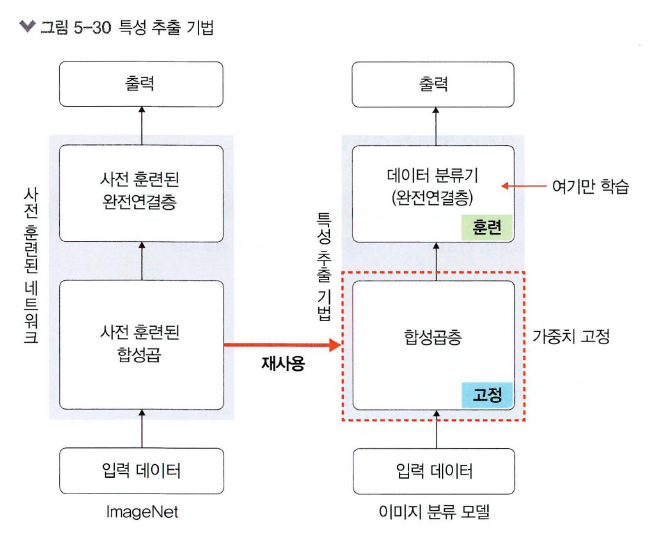

In [ ]:
# 라이브러리 설치
!pip install opencv-python

In [1]:
# 라이브러리 호출
import os
import time
import copy
import glob
import cv2 # 앞에서 설지한 OpenCV 라이브러리
import shutil

import torch
import torchvision # 컴퓨터 비전 용도의 패키지
import torchvision.transforms as transforms # 데이터 전처리를 위해 사용되는 패키지
import torchvision.models as models # 다양한 파이토치 네트워크를 사용할 수 있도록 도와주는 패키지
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [4]:
# 이미지 데이터 전처리 방법 정의
data_path = '//content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/train'


transform = transforms.Compose(
    [
        transforms.Resize([256,256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])      # (1)

train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)           # (2)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle = True
)           # (3)

print(len(train_dataset))

385


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


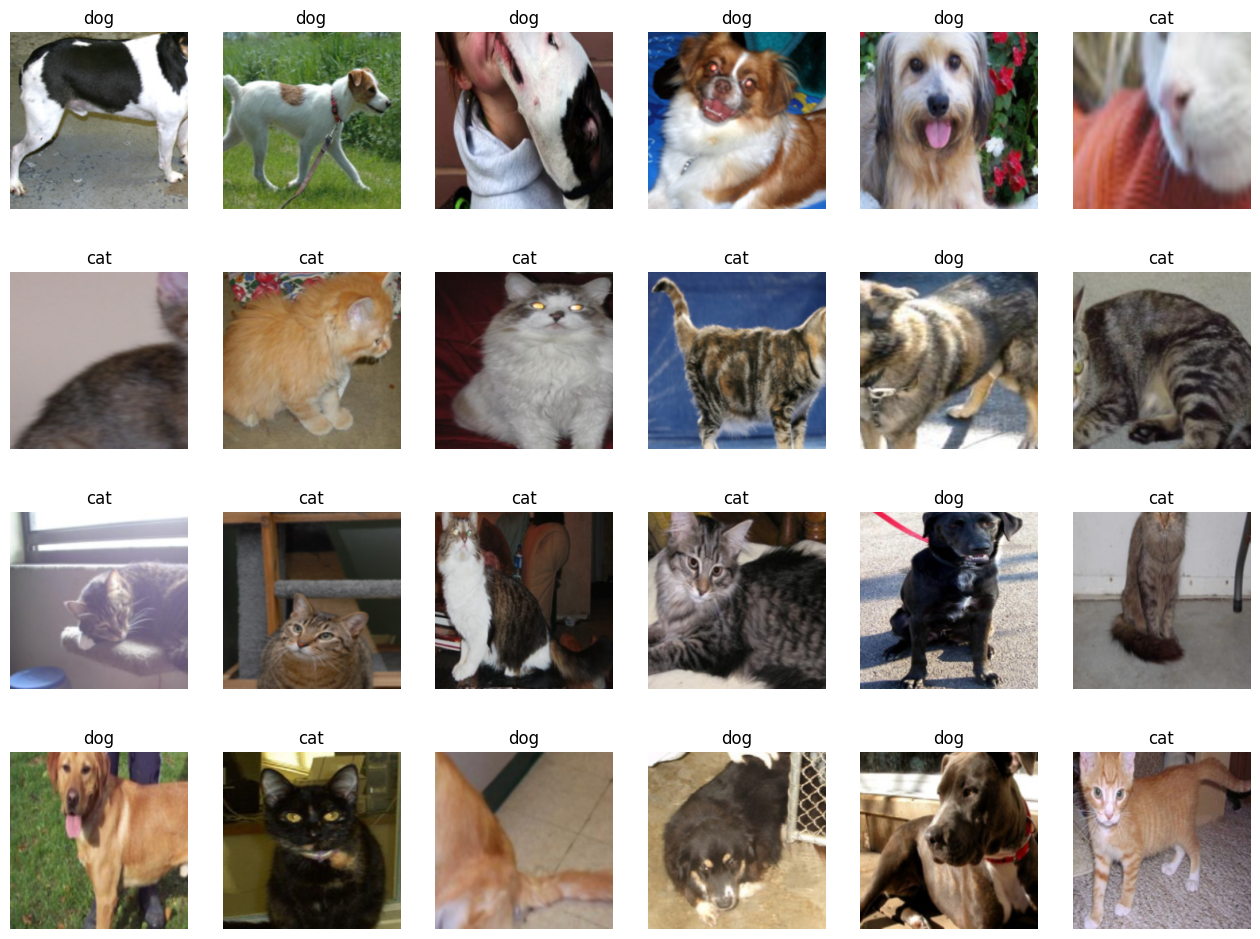

In [5]:
# 학습에 사용될 이미지 출력
import numpy as np

samples, labels = next(iter(train_loader)) # iter는 전달된 데이터의 반복자를 꺼내 반환하며, next는 그 방복자가 다음에 출력해야 할 요소를 반환한다.
classes = {0:'cat', 1:'dog'} # 개와 고양이에 대한 클래스로 구성
fig = plt.figure(figsize=(16, 24))
for i in range(24): # 24개의 이미지 데이터 출력
    a = fig.add_subplot(4, 6, i+1)
    a.set_title(classes[labels[i].item()]) # 레이블 정보(클래스)를 함께 출력
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1, 2, 0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [6]:
# 사전 훈련된 모델 내려받기
resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 117MB/s]


In [14]:
# 사전 훈련된 모델의 파라미터 학습 유무 지정
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False # 역전파 중 파라미터들에 대한 변화를 계싼할 필요 없음을 나타냄

set_parameter_requires_grad(resnet18)

In [15]:
# ResNet18에 완전연결층 추가 - 개와 고양이 클래스 분류에 사용

resnet18.fc = nn.Linear(512, 2) # 2는 클래스가 2개임을 의미

In [16]:
# 모델의 파라미터 값 확인

for name, param in resnet18.named_parameters() :
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0320, -0.0144, -0.0169,  ...,  0.0368,  0.0236,  0.0330],
        [-0.0044,  0.0009,  0.0432,  ..., -0.0405,  0.0247, -0.0115]])
fc.bias tensor([ 0.0026, -0.0031])


In [17]:
# 모델 객체 생성 및 손실 함수 정의

model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
# 모델 학습을 위한 함수 생성

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history, loss_history

In [22]:
# 파라미터 학습 결과를 옵티마이저에 전달

params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [23]:
# 모델 학습

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss: 0.3698 Acc: 0.8494

Epoch 1/12
----------
Loss: 0.3571 Acc: 0.8416

Epoch 2/12
----------
Loss: 0.3182 Acc: 0.8675

Epoch 3/12
----------
Loss: 0.3124 Acc: 0.8649

Epoch 4/12
----------
Loss: 0.2625 Acc: 0.8831

Epoch 5/12
----------
Loss: 0.2566 Acc: 0.8857

Epoch 6/12
----------
Loss: 0.3063 Acc: 0.8701

Epoch 7/12
----------
Loss: 0.3181 Acc: 0.8701

Epoch 8/12
----------
Loss: 0.2356 Acc: 0.8935

Epoch 9/12
----------
Loss: 0.2293 Acc: 0.9065

Epoch 10/12
----------
Loss: 0.2060 Acc: 0.9039

Epoch 11/12
----------
Loss: 0.2115 Acc: 0.8987

Epoch 12/12
----------
Loss: 0.2087 Acc: 0.9117

Training complete in 10m 13s
Best Acc: 0.911688


In [24]:
# 테스트 데이터 호출 및 전처리

test_path = '/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [25]:
# 테스트 데이터 평가 함수 생성

def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels.cpu()).int().sum()

        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history

In [26]:
# 테스트 데이터를 평가 함수에 적용

val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model ['/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/00.pth', '/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/01.pth', '/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/02.pth', '/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/03.pth', '/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/04.pth', '/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/05.pth', '/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/06.pth', '/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/07.pth', '/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/08.pth', '/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/09.pth', '/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/10.pth', '/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/11.pth', '/content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/12.pth']
Loading model /content/drive/MyDrive/ESAA/25-1 OB 세션/datasets

<ipython-input-25-010485e339d5>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Acc: 0.9082

Loading model /content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/01.pth
Acc: 0.9082

Loading model /content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/02.pth
Acc: 0.9388

Loading model /content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/03.pth
Acc: 0.9490

Loading model /content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/04.pth
Acc: 0.9082

Loading model /content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/05.pth
Acc: 0.9388

Loading model /content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/06.pth
Acc: 0.9082

Loading model /content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/07.pth
Acc: 0.9388

Loading model /content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/08.pth
Acc: 0.9082

Loading model /content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/09.pth
Acc: 0.9694

Loading model /content/drive/MyDrive/ESAA/25-1 OB 세션/datasets/catanddog/10.pth
Acc: 0.9082

Loading model /content/drive/MyDrive/

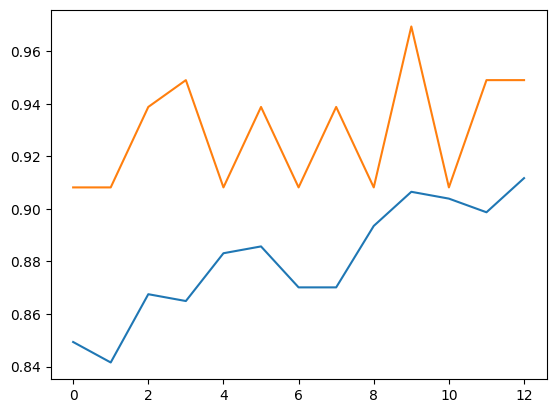

In [27]:
# 훈련과 테스트 데이터의 정확도를 그래프로 확인

plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

훈련과 테스트 데이터 모두 에포크가 진행될수록 정확도가 높아짐

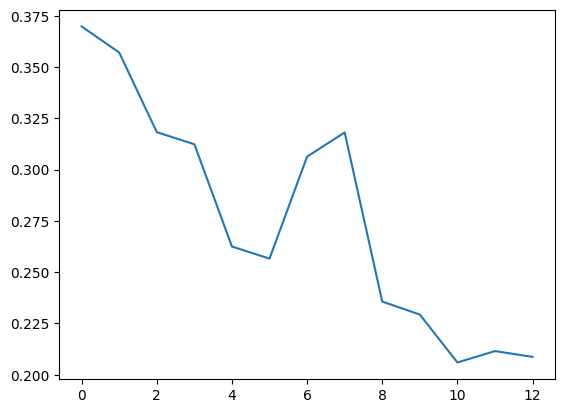

In [28]:
# 훈련 데이터의 오차에 대한 그래프 확인

plt.plot(train_loss_hist)
plt.show()

에포크가 진행될수록 오차가 낮아지고 있기 때문에 학습이 잘되었다고 할 수 있음

In [29]:
# 예측 이미지 출력을 위한 전처리 함수

def im_convert(tensor):
    image=tensor.clone().detach().numpy()
    image=image.transpose(1,2,0)
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))
    image=image.clip(0,1)
    return image

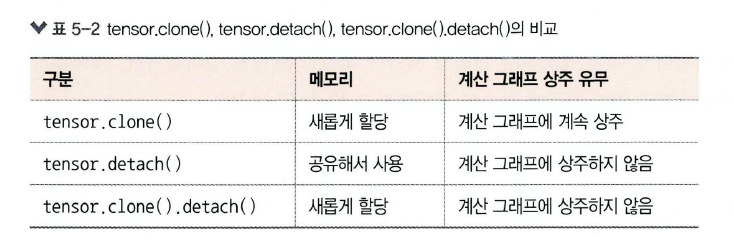

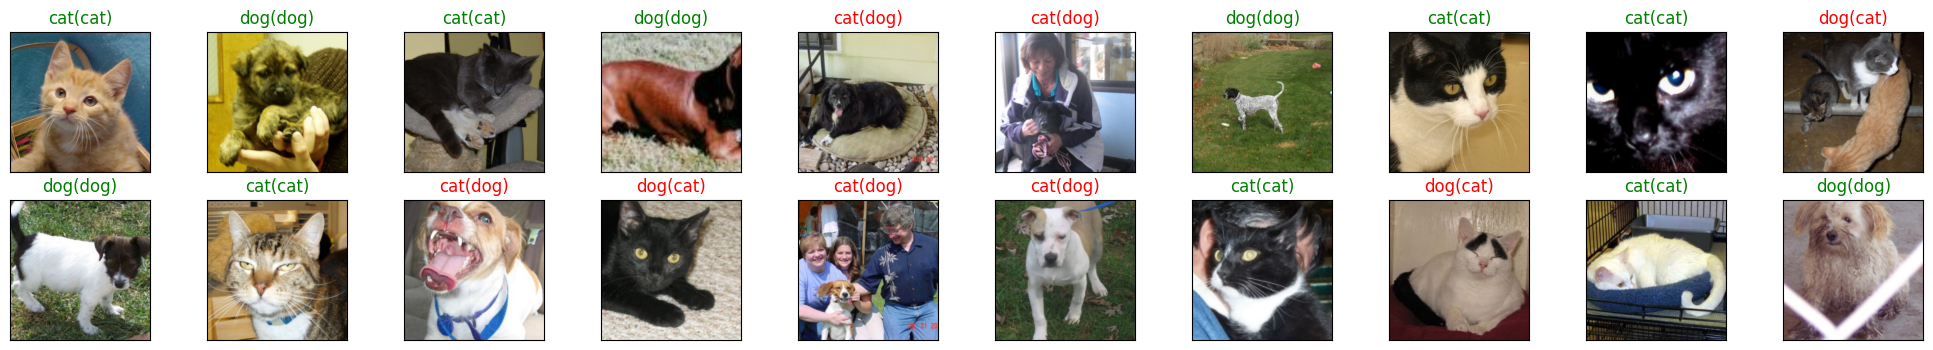

<Figure size 640x480 with 0 Axes>

In [30]:
# 개와 고양이 예측 결과 출력

classes = {0:'cat', 1:'dog'}

dataiter=iter(test_loader)
images,labels=next(dataiter)
output=model(images)
_,preds=torch.max(output,1)

fig=plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

## 5.3.2 미세 조정 기법

**미세 조정 기법**

특성 추출 기법에서 더 나아가 사전 훈련된 모델과 합성곱층, 데이터 분류기의 가중치를 업데이트하여 훈련시키는 방식

목표 특성을 잘 추출했다는 전제하에 좋은 성능을 낼 수 있음

특성이 잘못 추출되었을 경우 미세 조정 기법으로 새로운 이미지 데이터를 사용하여 네트워크의 가중치를 업데이트해서 특성을 다시 추출할 수 있음

즉, 사전 학습된 모델을 목적에 맞게 재학습시키거나 학습된 가중치의 일부를 재학습시키는 것

[미세 조정 기법 전략]

- 데이터셋이 크고 사전 훈련된 모델과 유사성이 작을 경우 : 모델 전체를 재학습시킴, 데이터셋의 크기가 크기 때문에 재학습시키는 것이 좋은 전략임

- 데이터셋이 크고 사전 훈련된 모델과 유사성이 클 경우 : 합성곱층의 뒷부분과 데이터 분류기를 학습시킴, 데이터셋이 유사하기 때문에 전체를 학습시키는 것보다는 강한 특징이 나타나는 합성곱층의 뒷부분과 데이터 분류기만 새로 학습하더라도 최적의 성능 낼 수 있음

- 데이터셋이 작고 사전 훈련된 모델과 유사성이 작을 경우 : 합성곱층의 일부분과 데이터 분류기를 학습시킴, 데이터가 적기 때문에 일부 계층에 미세 조정 기법을 적용한다고 해도 효과 없을 수 있음

- 데이터셋이 작고 사전 훈련된 모델과 유사성이 클 경우 : 데이터 분류기만 학습시킴, 데이터가 적기 때문에 많은 계층에 미세 조정 기법을 적용하면 과적합 발생 가능

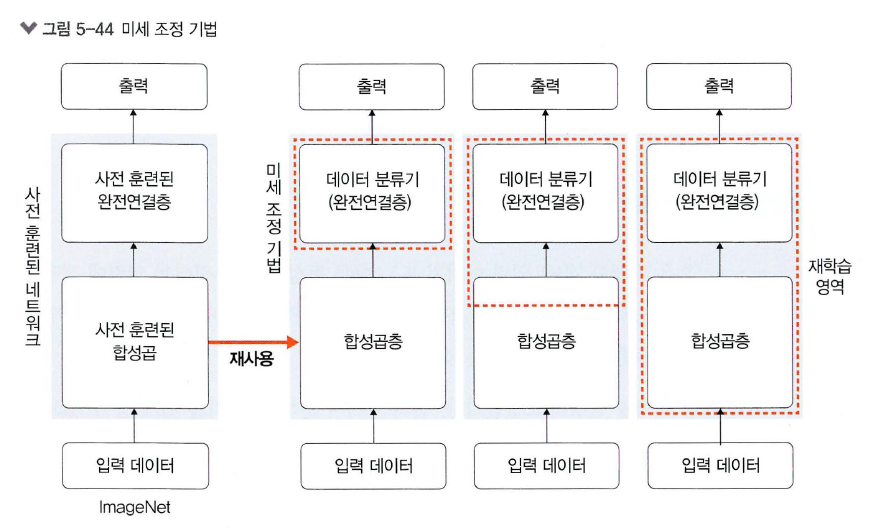